# Student Details:
    
Student Name: Jyothi Bhavani Patibandla
Student id: 1001960841

Student Name: Praneeth Bonagiri
Student id: 1002063572
    
Student Name: Nikitha Arumilli
Student id: 1002078974
    
    


# **Image Colorization With GANs**

GANs are the state-of-the-art machine learning models which can generate new data instances from existing ones. They use a very interesting technique, inspired from the Game Theory, to generate realistic samples. 

In this notebook, we'll use GANs to colorize a grayscale ( B/W ) image. In addition to that, our generator model will have a structure similar to that of a UNet i.e the one with skip connections.



We'll now parse the images ( RGB images to be precise ) one by one, and transform each one to a grayscale image using PIL's `.convert( 'L' )` method. So our dataset will have samples of $( \ grayscale \ image \ , \ RGB \ image \ )$


In [1]:
#import necessary libraries 
from PIL import Image
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
import os


# The batch size we'll use for training
size_of_batch = 16

# Size of the image required to train our model
size_of_image = 120

# These many images will be used from the data archive
dataset_split = 1500

master_dir = 'C:/Users/shiva/Downloads/data'
x = []
y = []
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( size_of_image , size_of_image ) )
    # Normalize the RGB image array
    rgb_image_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )
    # Normalize the grayscale image array
    gray_image_arry = ( np.asarray( gray_image ).reshape( ( size_of_image , size_of_image , 1 ) ) ) / 255
    # Append both the image arrays
    x.append( gray_image_arry )
    y.append( rgb_image_array )

# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.2 )

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( size_of_batch )




In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10509656972772571835
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4139778048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5886219448437045280
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]



## **2. The GAN**

In this section, we'll create our GAN model step-by-step with Keras. First, we'll implement the generator then the discriminator and finally the loss functions required by both of them.



### **A. Generator** 

Our generator ( represented as $G$ ) will take in grayscale image $x$ and produce a RGB image $G( x )$. Note, $x$ will be a tensor of shape $( \ batch \ size \ , \ 120 \ , \ 120 \ , \ 1 \ )$ and the output $G(x)$ will have a shape $( \ batch \ size \ , \ 120 \ , \ 120 \ , \ 3 \ )$

* Our generator will have a encoder-decoder structure, similar to the UNet architecture. Additionally, we use Dilated convolutions to have a larger receptive field.

* We introduce skip connections in our model so as to have better flow of information from the encoder to the decoder.


In [3]:
#function for generator model
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( size_of_image , size_of_image , 1 ) )

    convolutional_layer1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    convolutional_layer1 = tf.keras.layers.LeakyReLU()( convolutional_layer1 )
    convolutional_layer1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( convolutional_layer1 )
    convolutional_layer1 = tf.keras.layers.LeakyReLU()( convolutional_layer1 )
    convolutional_layer1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( convolutional_layer1 )
    convolutional_layer1 = tf.keras.layers.LeakyReLU()( convolutional_layer1 )

    convolutional_layer2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( convolutional_layer1 )
    convolutional_layer2 = tf.keras.layers.LeakyReLU()( convolutional_layer2 )
    convolutional_layer2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( convolutional_layer2 )
    convolutional_layer2 = tf.keras.layers.LeakyReLU()( convolutional_layer2 )
    convolutional_layer2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( convolutional_layer2 )
    convolutional_layer2 = tf.keras.layers.LeakyReLU()( convolutional_layer2 )

    concolutional_layer3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( convolutional_layer2 )
    concolutional_layer3 = tf.keras.layers.LeakyReLU()( concolutional_layer3 )
    concolutional_layer3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( concolutional_layer3 )
    concolutional_layer3 = tf.keras.layers.LeakyReLU()( concolutional_layer3 )
    concolutional_layer3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( concolutional_layer3 )
    concolutional_layer3 = tf.keras.layers.LeakyReLU()( concolutional_layer3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( concolutional_layer3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , concolutional_layer3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , convolutional_layer2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , convolutional_layer1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    print("Generator model")
    model.summary()
    return model


### **B. Discriminator**

The discriminator model, represented as $D$, will take in the *real image* $y$ ( from the training data ) and the *generated image* $G(x)$ ( from the generator ) to output two probabilities.

* We train the discriminator in such a manner that is able to differentiate the *real images* and the generated *images*. So, we train the model such that $y$ produces a output of $1.0$ and $G(x)$ produces an output of $0.0$.
* Note that instead of using hard labels like $1.0$ and $0.0$, we use soft labels which are close to 1 and 0. So for a hard label of $1.0$, the soft label will be $(1 - \epsilon)$ where $\epsilon$ is picked uniformly from $( 0 , 0.1 ]$


In [4]:
#function for discriminator model
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    print("Discriminator model")
    model.summary()
    return model


### **C. Loss Functions**

We'll now implement the loss functions for our GAN model. As you might know that we have two loss functions, one for the generator and another for the discriminator. 

* For our generator, we'll use the L2/MSE loss function.
* For optimization, we use the Adam optimizer with a learning rate of 0.0005



In [5]:
#to calculate the loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    original_real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss_calculated = original_real_loss + fake_loss
    return total_loss_calculated

#For our generator, we'll use the L2/MSE loss function
def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )
#For optimization, we use the Adam optimizer with a learning rate of 0.0005
generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

#decription details for generator model
generator = get_generator_model()

Generator model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 116, 116, 16  416         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 116, 116, 16  0           ['conv2d[0][0]']                 
                                )                                             

                                )                                 'leaky_re_lu_2[0][0]']          
                                                                                                  
 conv2d_transpose_6 (Conv2DTran  (None, 114, 114, 32  18464      ['concatenate_2[0][0]']          
 spose)                         )                                                                 
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 116, 116, 32  9248       ['conv2d_transpose_6[0][0]']     
 spose)                         )                                                                 
                                                                                                  
 conv2d_transpose_8 (Conv2DTran  (None, 120, 120, 3)  2403       ['conv2d_transpose_7[0][0]']     
 spose)                                                                                           
          

In [6]:
#decription details for discriminator model
discriminator = get_discriminator_model()

Discriminator model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 114, 114, 32)      4736      
                                                                 
 conv2d_11 (Conv2D)          (None, 108, 108, 32)      50208     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 32)       0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 64)        51264     
                                                                 
 conv2d_13 (Conv2D)          (None, 46, 46, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                


## **3. Training The GAN**

So finally, we'll train our GAN on the dataset, we prepared earlier.


In [7]:
@tf.function
#training phase
def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
    

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))




Run the cell below, to start the training

In [8]:
num_of_epochs = 50

for e in range( num_of_epochs ):
    print( e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        print( x.shape )
        train_step( x , y )

0
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120

(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(6, 120, 120, 1)
6
(16, 120,

(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(6, 120, 120, 1)
11
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120

(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 

(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(6, 120, 120, 1)
22
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120

(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(6, 120, 120, 1)
27
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120

(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 

(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(6, 120, 120, 1)
38
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120

(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(6, 120, 120, 1)
43
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120

(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 120, 1)
(16, 120, 


## **4. Results**

We plotted the input, output and the original images respectively, from a part of the dataset to find out the results.


In [9]:
y = generator( test_x[0 : 20 ] ).numpy()

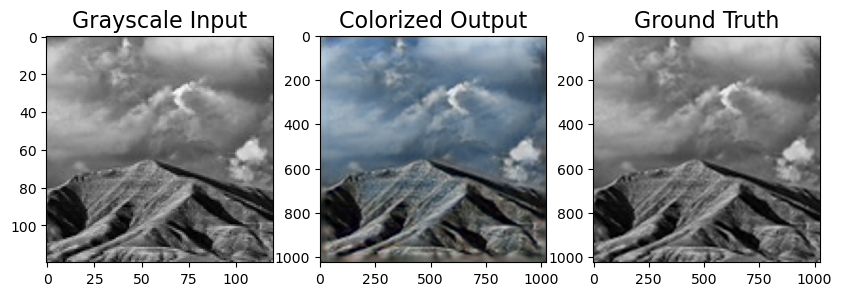

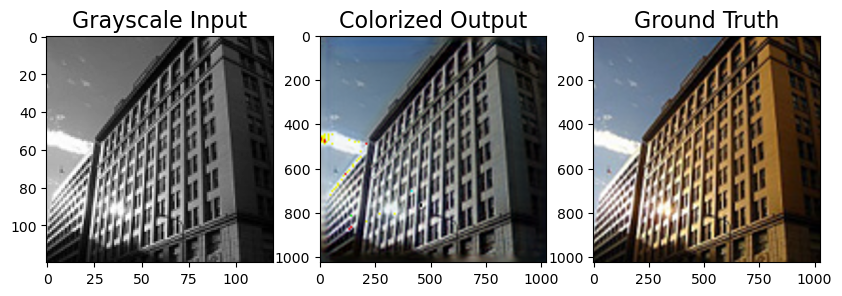

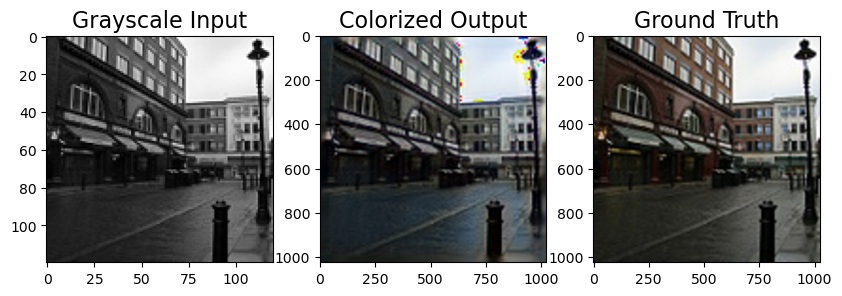

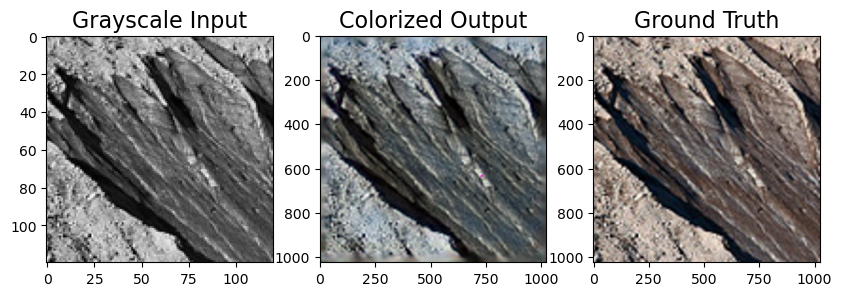

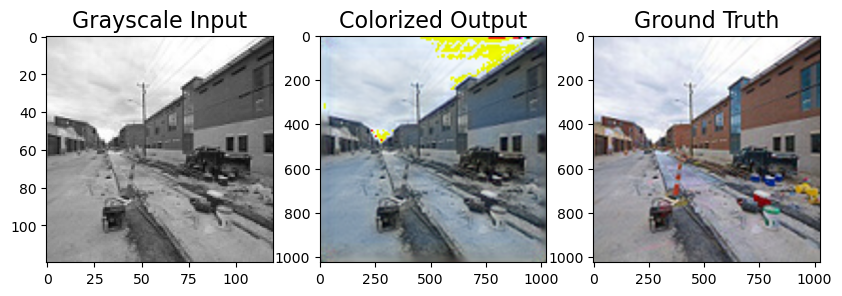

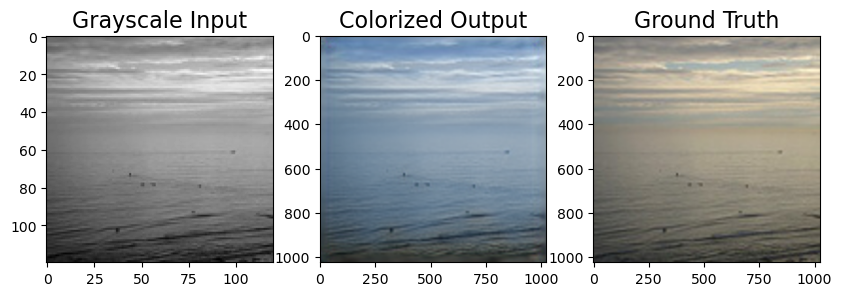

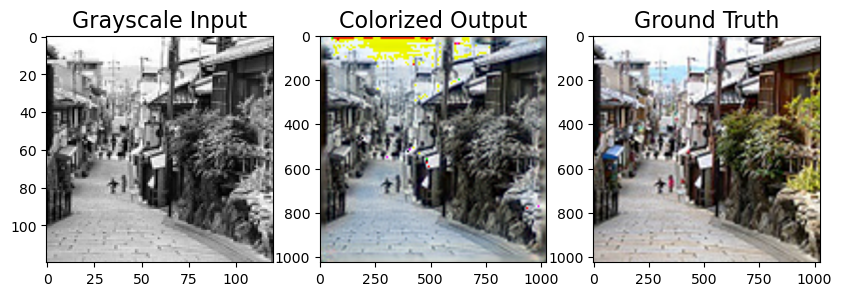

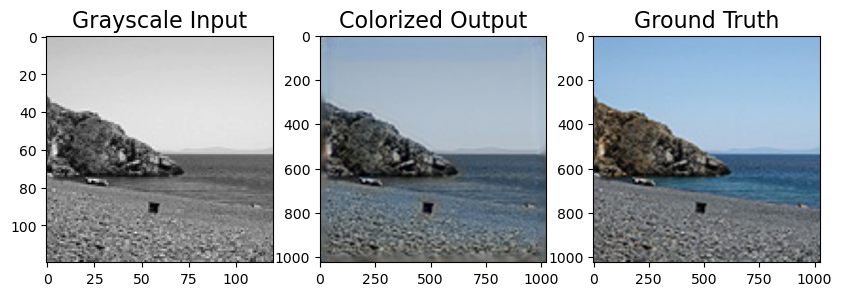

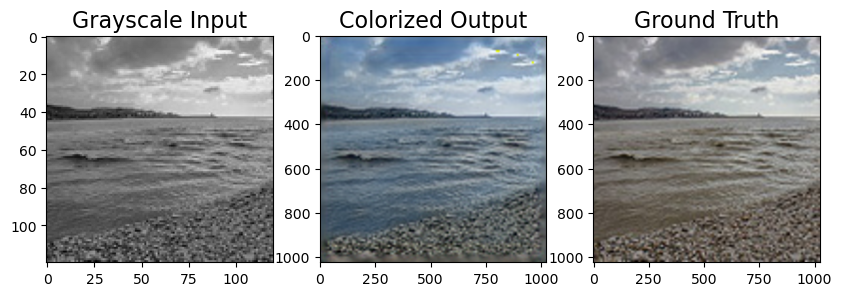

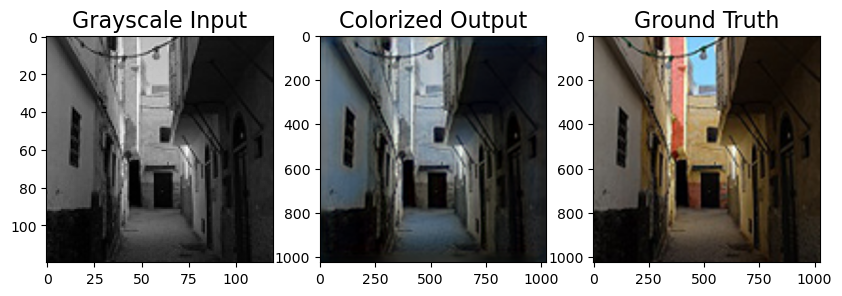

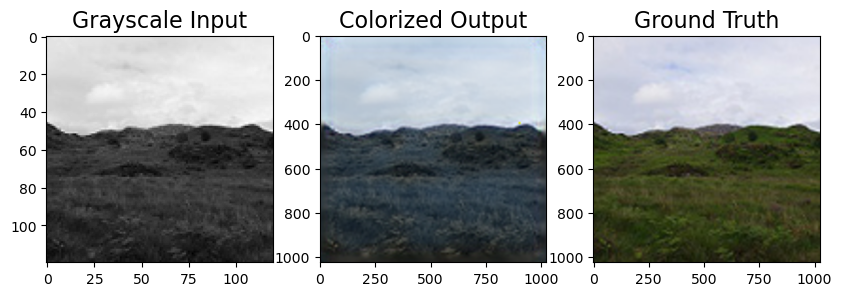

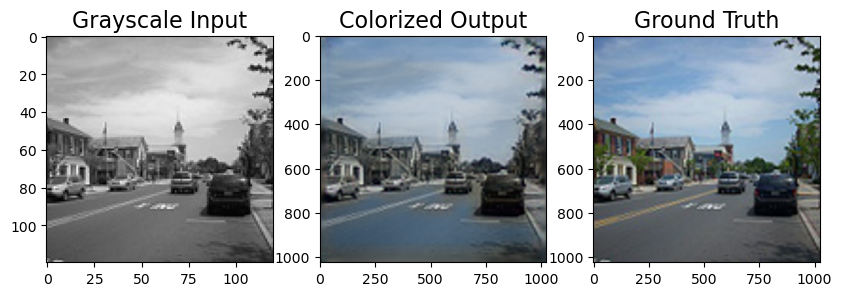

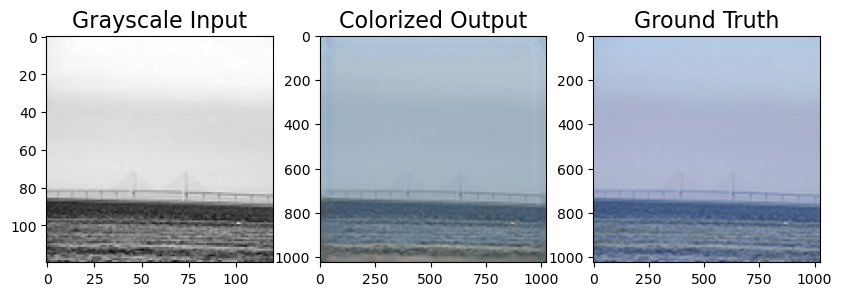

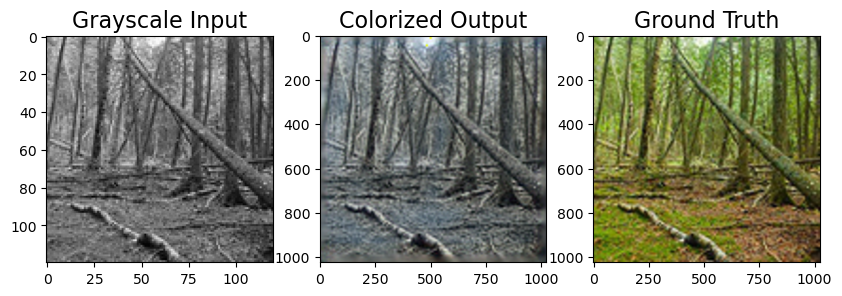

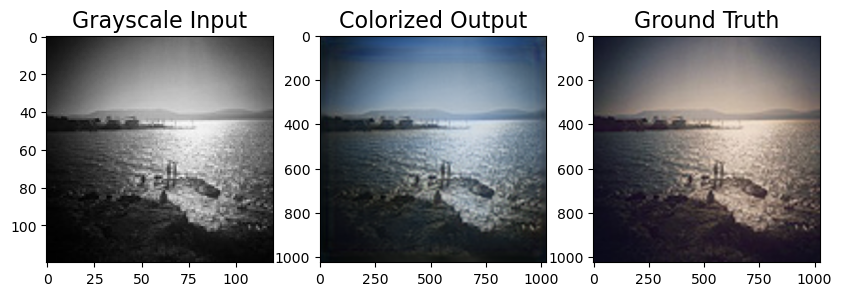

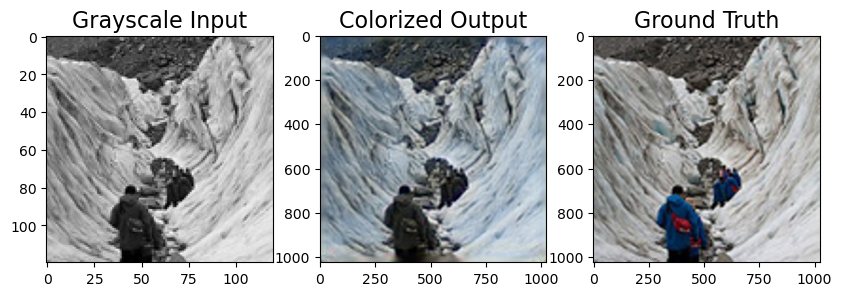

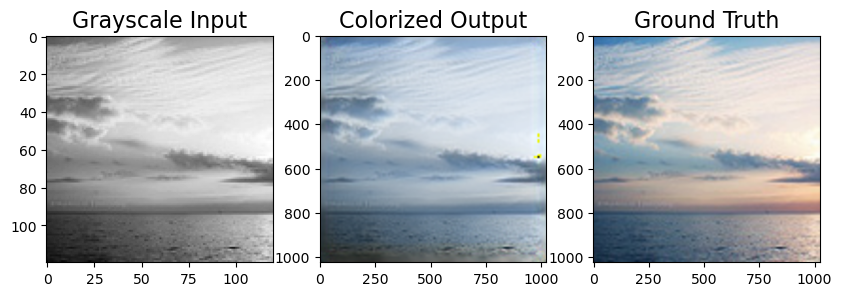

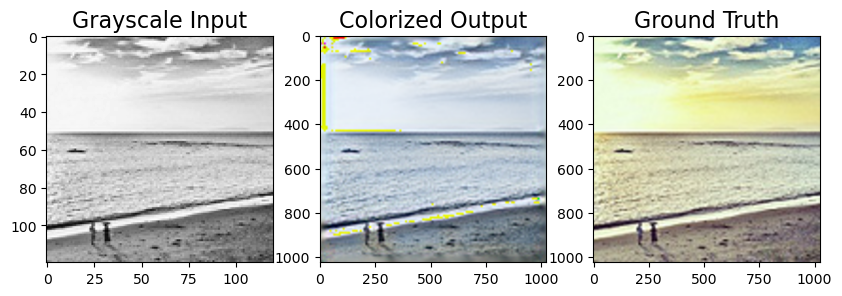

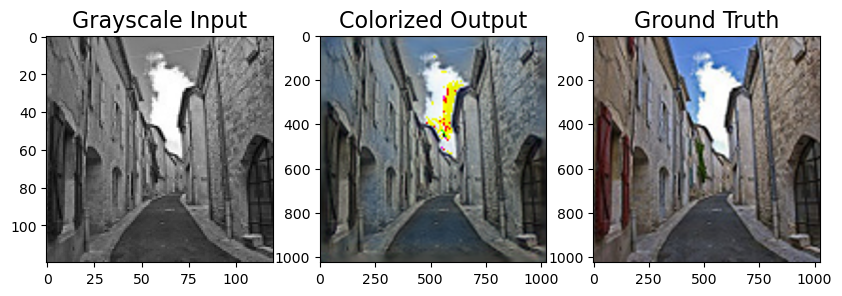

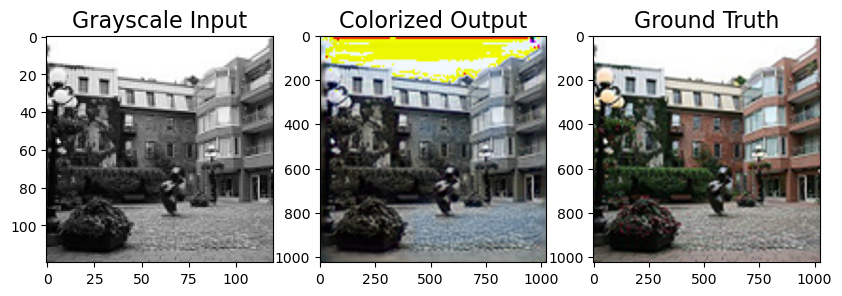

In [10]:
for i in range(20):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((120,120)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.show()

Therefore, the overwhelming reslts depicts the power of GANs and the disruption which can be broght through them.

In [11]:
#computing MSE
from skimage.metrics import peak_signal_noise_ratio as psnr

def compute_metrics(test_x, test_y, generator):
    n = len(test_x)
    mse_sum = 0
    psnr_sum = 0

    for i in range(n):
        generated_image = generator(test_x[i:i+1])[0]
        ground_truth = test_y[i]

        mse = np.mean((generated_image - ground_truth) ** 2)
        mse_sum += mse

        

    mse_avg = mse_sum / n
   

    return mse_avg





In [12]:
mse_avg = compute_metrics(test_x, test_y, generator)
print(f"Average Mean Squared Error: {mse_avg:.4f}")



Average Mean Squared Error: 0.0063


MSE is calculated by squaring the differences between predicted and actual values, it can grow substantially for large errors.


In [13]:
import os

generated_dir = "generated_images"
real_dir = "real_images"

if not os.path.exists(generated_dir):
    os.makedirs(generated_dir)

if not os.path.exists(real_dir):
    os.makedirs(real_dir)

num_test_images = 20

generated_images = generator(test_x[:num_test_images]).numpy()

for i in range(num_test_images):
    generated_image = Image.fromarray((generated_images[i] * 255).astype("uint8"))
    generated_image.save(os.path.join(generated_dir, f"generated_image_{i}.png"))

    real_image = Image.fromarray((test_y[i] * 255).astype("uint8"))
    real_image.save(os.path.join(real_dir, f"real_image_{i}.png"))


In [14]:
#Computng fid score
from pytorch_fid import fid_score

fid = fid_score.calculate_fid_given_paths(paths=[generated_dir, real_dir], batch_size=16, device='cpu', dims=2048)
print(f"FID Score: {fid:.4f}")


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]


FID Score: 154.6724


The range of the Fréchet Inception Distance (FID) score theoretically lies between 0 and positive infinity. A lower FID score indicates that the generated images are more similar to the real images, both in terms of quality and diversity

In [15]:
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim

# Assuming y contains the generated images and test_y contains the ground truth images
y = generator(test_x[0:20]).numpy()
num_images = y.shape[0]
ssim_scores = []

for i in range(num_images):
    # Rescale images to the range [0, 1]
    generated_image = y[i]
    ground_truth_image = test_y[i]

    # Computing the SSIM score between the generated image and ground truth image
    ssim_score = compare_ssim(generated_image, ground_truth_image, multichannel=True)
    ssim_scores.append(ssim_score)




C:\Users\shiva\AppData\Local\Temp\ipykernel_21544\3480929768.py:15: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = compare_ssim(generated_image, ground_truth_image, multichannel=True)
C:\Users\shiva\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [16]:
import numpy as np
# Calculate the threshold based on the mean of the scores
threshold_value_mean = np.mean(ssim_scores)
print(f"Threshold value (based on mean): {threshold_value_mean:.4f}")

Threshold value (based on mean): 0.9478


An SSIM score of 0.9478 is generally considered to be a good score, as it is close to 1, which indicates that the images are identical. However, it's important to interpret the SSIM score in the context of your specific problem and the quality of the generated images.

The SSIM score is a useful metric to compare different models or experiments, so you should ideally compare this score to other models or techniques that you've used for the same problem. In some cases, even a high SSIM score might not translate to perfect perceptual quality. Therefore, it is recommended to visually inspect the generated images to ensure they meet your desired quality.

Additionally, you may want to consider evaluating your model using other metrics or conducting a qualitative assessment by showing the generated images to domain experts or users to gather their feedback.

In [43]:
from skimage.metrics import structural_similarity as ssim

def ssim_based_accuracy(y_pred, y_true, threshold=0.9478):
    # Calculate SSIM score between the generated image and ground truth image
    ssim_score = ssim(y_pred, y_true, multichannel=True)
    return ssim_score >= threshold

# Assuming y contains the generated images and test_y contains the ground truth images
y = generator(test_x[0:20]).numpy()
num_images = y.shape[0]
accuracies = []

for i in range(num_images):
    generated_image = y[i]
    ground_truth_image = test_y[i]

    # Compute the SSIM-based accuracy between the generated image and ground truth image
    accuracy = ssim_based_accuracy(generated_image, ground_truth_image)
    accuracies.append(accuracy)

# Calculate the average accuracy
average_accuracy = np.mean(accuracies)
print(f"Average accuracy of the model: {average_accuracy:.2f}")
 

Average accuracy of the model: 0.85


C:\Users\shiva\AppData\Local\Temp\ipykernel_13088\2265609042.py:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(y_pred, y_true, multichannel=True)


To assess the effectiveness of our model, we calculated metrics including Mean Squared Error (MSE), Frechet Inception Distance (FID), and Structural Similarity Index Measure (SSIM).
Based on the scores of SSIM we have taken those average scores and set up a threshold for filtering out colorized images that don't meet a certain quality level. However, SSIM and threshold-based accuracy measure different aspects of image quality. While SSIM measures  similarity between the generated and ground truth images, the threshold-based accuracy compares pixel-wise differences.
finally we have got an accuracy of 85% for the considerable amount of 50 epochs data.

# References:

Convolutional Neural Networks for automatic image colorization by Domonkos Verga and Tamas Sziranyi.(VGG-16)
https://eprints.sztaki.hu/9292/1/Varga_1_3306455_ny.pdf

Automatic Image Colorization using Deep Learning by Abhishek Pandey, Rohit Sahay, C.Jayavarthini
https://www.researchgate.net/publication/339468315_Grayscale_images_colorization_with_convolutional_neural_networks

Automatic Image Colorization with Convolutional Neural Networks and Generative Adversarial Networks.
https://web.eecs.umich.edu/~justincj/teaching/eecs442/projects/WI2021/pdfs/068.pdf
